# Advanced Econometrics III
## Assignment 1
The volatility index (VIX) is a measure of the volatility of the S&P 500 index, constructed from option prices; see https://www.cboe.com/micro/vix/vixwhite.pdf. The file VIX.csv contains daily data on the VIX over the years 1991–2017. We are going to work with the natural logarithm of the VIX given by $Xt = \ln(\text{VIX}_{t})$. Before we start answering the questions, we first import the data into the notebook.

In [2]:
# Download the data from Github. Note that the file is first deleted if it
# already exists in the directory.
!rm -f VIX.csv
!wget https://raw.githubusercontent.com/Mathijs995/Advanced-Econometrics-III/master/VIX.csv

# List the files in the current folder to show the download was successful.
!ls

--2019-03-20 20:45:51--  https://raw.githubusercontent.com/Mathijs995/Advanced-Econometrics-III/master/VIX.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 116104 (113K) [text/plain]
Saving to: ‘VIX.csv’

VIX.csv             100%[===================>] 113.38K  --.-KB/s    in 0.04s   

2019-03-20 20:45:51 (3.03 MB/s) - ‘VIX.csv’ saved [116104/116104]

sample_data  VIX.csv


Before we import the VIX data into this notebook, we first import the packages used in the notebook.

In [0]:
import pandas as pd
import numpy as np
import scipy
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

We continue by importing and transforming the data.

In [0]:
# Import the VIX data.
data = pd.read_csv("VIX.csv")

# Define the X_t variable.
X = np.log(data["VIX"].values)
X = X.reshape((X.shape[0],1))

### Question 1
Make a time series plot of $X_{t}$ and of its first difference $\Delta X_{t}$. Next, make a plot of the sample autocorrelation functions $\gamma^{n}(h)$ of $X_{t}$ and of $\Delta X_{t}$, for $h = 1, \ldots , 50$. Judging from these plots, would you choose to model $X_{t}$ as a stationary and invertible ARMA process, or would you start building such a model for $\Delta X_{t}$?

#### Answer to question 1
The code below first derive the first difference $\Delta X_{t}$. Afterwards, the autocorrelation functions $\gamma^{n}(h)$ of $X_{t}$ and of $\Delta X_{t}$, for $h = 1, \ldots , 50$ are plotted.

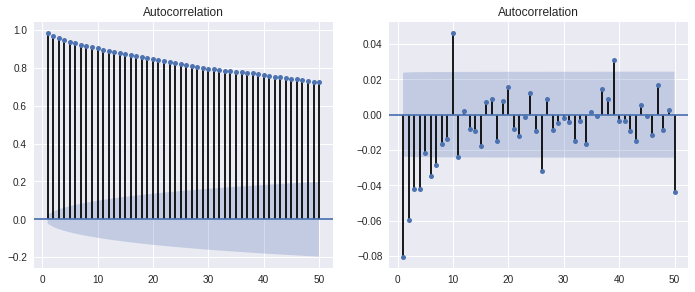

In [45]:
# Define the first difference variable.
fd_X = np.diff(X.reshape(X.shape[0],))

# Define lag constants.
MIN_LAG = 1
MAX_LAG = 50

# Plot the autocorrelation functions.
fig, axes = plt.subplots(1, 2)
fig = plot_acf(X, lags=range(MIN_LAG, MAX_LAG + 1), ax=axes[0])
fig = plot_acf(fd_X, lags=range(MIN_LAG, MAX_LAG + 1), ax=axes[1])
fig.tight_layout()
fig.set_size_inches(10, 4)

Judging from the plots, $X_{t}$ does not seem to be a stationary and invertible ARMA process while $\Delta X_{t}$ seems to be stationary and invertible. Hence, we would start building a model for $\Delta X_{t}$.

### Question 2
A formal answer to the question whether differencing is needed for stationarity can be obtained from a unit root (Dickey-Fuller) test. This is a test for $H_{0} : X_{t} \sim I(1)$ against the alternative $H_{1} : X_{t} \sim I(0)$. The simplest version rejects the null hypothesis when $t_{\delta} < -2.86$, where $t_{\delta}$ is the $t$-ratio of $\delta$ in the OLS regression
$$\Delta X_{t} = \mu + \delta X_{t-1} + \gamma_{1}\Delta X_{t-1} + \ldots + \gamma_{p-1} \Delta X_{t-p+1} + \varepsilon_{t}.$$
The number of lags p can be chosen by minimising the Schwarz criterion / BIC.

\[Note that -2.86 differs from the usual 5% critical value for $t$-ratios, because the asymptotic distribution theory for these tests is non-standard.\]

Carry out the test, and report on what you find. Is the result in agreement with your answer to question 1?

#### Answer to question 2
Before we find the optimal number of lags $p$ according to the Scharz criterion / BIC, we introduce a new function that returns the regressor matrix and the regressand vector given a number of lags $p$.

In [0]:
def regressors_given_p(fd_X, X, p):
    """
    Purpose:
      Constructs the regressor matrix mX and the regressand vector vY
      for a given number of lags p.

    Inputs:
      fd_X    np.array, first differenced dependent variable
      X       np.array, dependent variable
      p       int, number of lags

    Return value:
      vY      np.array, regressand vector of the model
      mX      np.array, regressor matrix of the model
    """
    ones = np.ones((len(X)-p-1))
    ones = ones.reshape((ones.shape[0],1))
    vY = fd_X[p:]
    mX = np.concatenate((ones, X[p:-1], np.concatenate([fd_X[p - i - 1: - i - 1] for i in range(p)], axis=1)), axis=1)
    return vY, mX

Now that we have a function that returns the regressor matrix and the regressand vector for a given number of lags, we can find the optimal number of lags $p$ according to the Scharz criterion / BIC.

In [63]:
# Define the minimum and maximum number of lags.
MIN_P = 1
MAX_P = 10
BIC_scores = []

# Reshape the first differenced regressand vector to be able to use it.
fd_X = fd_X.reshape(fd_X.shape[0], 1)


def get_BIC(vY, mX, vB):
  """
  Purpose:
    Computes the value of the BIC given data and parameters.

  Inputs:
    vY      np.array, regressand vector
    mX      np.array, regressor matrix
    vB      np.array, OLS estimator

  Return value:
    BIC     float, value of the BIC
  """
  N = len(vY)
  K = len(mX.T)
  resid = vY - mX @ vB
  SSE = sum(resid**2)
  BIC = N * np.log(SSE / N) + K * np.log(N)
  return BIC


# Finding the optimal number of lags p.
for p in range(MIN_P, MAX_P + 1):
  vY, mX = regressors_given_p(fd_X, X, p)
  vB = np.linalg.inv(mX.T @ mX) @ mX.T @ vY
  BIC = get_BIC(vY, mX, vB)
  BIC_scores.append(BIC)

# Get the optimal number of lags.
opt_p = np.argmin(BIC_scores) + 1

# Initialize the regressand vector, the regressor matrix and the OLS estimator
# for the optimal number of lags.
vY, mX = regressors_given_p(fd_X, X, opt_p)
vB = np.linalg.inv(mX.T @ mX) @ mX.T @ vY

# Print the optimal number of lags to the console with the corresponding BIC value.
print("The optimal number of lags is {} with a BIC value of {}.".format(opt_p, float(BIC_scores[opt_p - 1])))

The optimal number of lags is 4 with a BIC value of -37645.98672474383.


Before we carry out the Dickey-Fuller test, we first initialize a method that can be used to find the $t$-statistic for a given parameter and a given null hypothesis in the model defined above.

In [0]:
def t_statistic(vY, mX, vB, ind_par, h0):
    """Purpose: Returns the t-statistic for the given parameter par and h0
    Inputs: vY,mX,vB, par
    Returns: t
    """
    """
    Purpose:
      Computes the t-statistic for a given parameter with index par_ind and a
      given null hypothesis h0.

    Inputs:
      vY      np.array, regressand vector
      mX      np.array, regressor matrix
      vB      np.array, OLS estimator
      ind_par int, index of parameter to compute the t-statistic for
      h0      float, value of the parameter under the null hypothesis

    Return value:
      t       float, t-statistic
    """
    N = len(vY)
    K = len(mX.T)
    resid = vY - mX @ vB
    SSE = sum(resid**2)
    
    # Estimate covariance matrix
    mCov_hat = np.linalg.inv(mX.T @ mX) * SSE / (N - K)
    
    # Compute the t-statistic.
    t = (vB[par_ind] - h0) / np.sqrt(np.diag(mCov_hat)[par_ind])
    
    return t


We continue by carrying out the Dickey-Fuller test.

In [67]:
# Define the parameter inputs for the Dickey-Fuller test.
par_ind = 1 # We are interested in the second parameter delta.
h0 = 0 # We test the null hypothesis X is integrated of order one which implies
       # that delta should be equal to 0.
  
# Apply the Dickey-Fuller test.
t = t_statistic(vY, mX, vB, par_ind, h0)
print('The point estimate for delta is {}.'.format(vB[par_ind]))
print('The t-statistic for testing whether the process is integrated of ',
          'order one is {}.'.format(t))

The point estimate for delta is [-0.01271429].
The t-statistic for testing whether the process is integrated of  order one is [-5.81684526]


We get a high $t$-statistic because even though $\hat{\delta}$ is close to 0, it is very precisely estimated ($n=6800$). In conclusion, the null hypothesis is rejected and we conclude that the process is **not** integrated of order one.

In [0]:
# Estimate spectral density
f,Pxx  = scipy.signal.periodogram(fd_X, window='bartlett')